<a href="https://colab.research.google.com/github/916jun/pdm02/blob/main/py-tensorflow/pdm02_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#transfer learning
tranfer learning 이란 한 가지 문제를 해결하고 다른 문제에 적용하면서 얻은 지식을 저장하는 데 중점을 둔  기계 학습입니다. 자동차, 고양이 등과 같은 사물이나, 동물을 인식하는 법을 학습시키고 얻은 지식은 다른 사물이나, 동물을 인식하려고 할 때 사용된다. 

cifar10 데이터 세트에서 10%의 데이터 5000개로 학습시킨 후 훈련 데이터와 검증 데이터에 대한 loss 와 accuracy 확인하고, Fine Tuning 했을때도 마찬가지로 정확도를 확인해보았다. 
그 결과 cifar10pct10_mobileNetV2F_SGD_FT_best_weights.057-0.8505.hdf5 으로 FINE Tuninng 을 했을 때 정확도가 높은 것으로 확인하였다.


In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


In [ ]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


In [ ]:
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
# print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

170508288/170498071 [==============================] - 2s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train , y_test = train_test_split(trainX,trainy,test_size=0.1,stratify=trainy, random_state=42)
print(X_test.shape, y_test.shape)
X_train, y_train,X_test, y_test = X_test,y_test, testX, testy
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

(5000, 32, 32, 3) (5000, 1)
Train: X=(5000, 32, 32, 3), y=(5000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

import os
# Matplotlib config
# plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='000000')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    true_index = n_labels[i]
    # Set x-label color: green if prediction correct and red if prediction incorrect
    plt.xlabel(classes[class_index])
    xlabel_color = "green" if n_predictions[i] == n_labels[i] else "red"
    ax.xaxis.label.set_color(xlabel_color) 
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

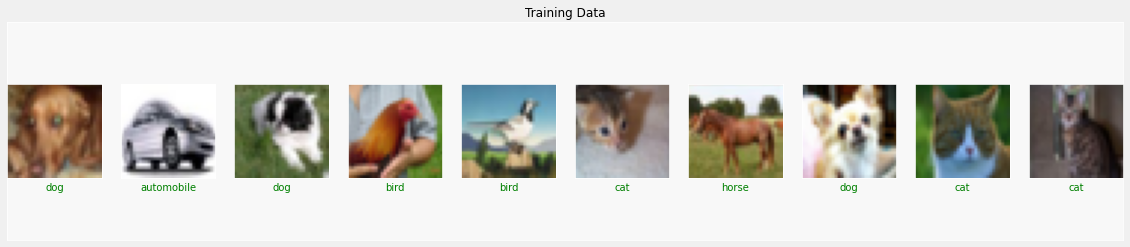

In [ ]:
display_images(trainX, trainy, trainy, "Training Data" )

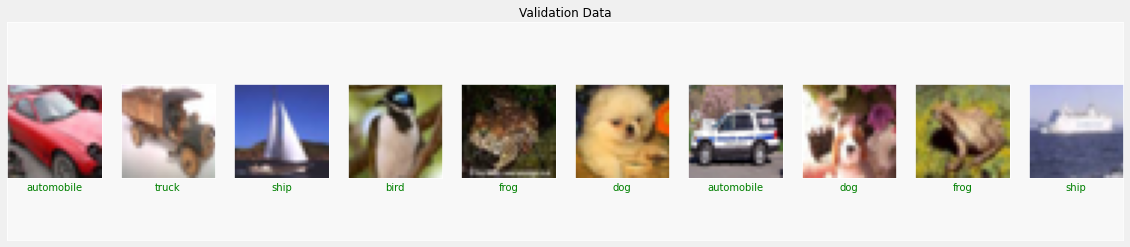

In [ ]:
display_images(testX, testy, testy, "Validation Data" )

In [ ]:
# data augmentation
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(X_train)

In [ ]:
#Reshape
img_rows,img_cols, channels = 32,32,3
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'samples')
print(X_test.shape[0], 'samples')

x_train shape: (5000, 32, 32, 3)
5000 train samples
10000 test samples


In [ ]:
X_train = X_train.astype("float32")
X_test=X_test.astype("float32")

In [ ]:
X_train.shape,len(X_train),X_train[4].shape

((5000, 32, 32, 3), 5000, (32, 32, 3))

In [ ]:
# tf.keras.utils.to_categorical
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_train.shape,y_test.shape

((5000, 10), (10000, 10))

In [ ]:
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
len(TL_base.layers)

154

In [ ]:
TL_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization


model = models.Sequential()
model.add(keras.Input(shape=(32,32,3)))
model.add(layers.UpSampling2D((7,7)))  # 32*7 = 224
model.add(TL_base)
model.add(layers.GlobalAveragePooling2D()) # (7,7,2048) => (2048,)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

# model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.compile(optimizer='SGD', 
                loss='categorical_crossentropy',  # categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

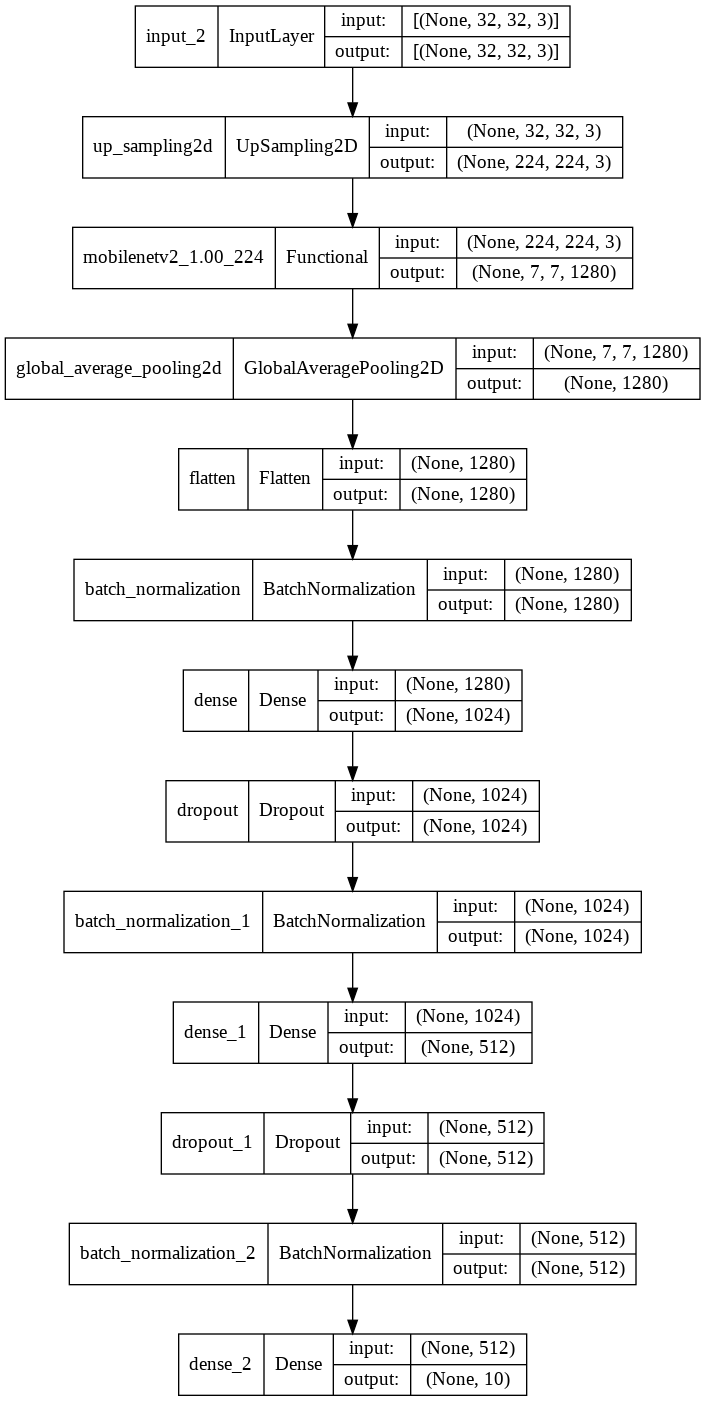

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10pct10_mobileNetV2F_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)


In [ ]:
EPOCHS = 500
BATCH_SIZE = 50  # 32, 50, 64, 100
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,  
                    batch_size=BATCH_SIZE,
                    callbacks=[mc_callback,es_callback],
                    validation_data = (X_test, y_test))

Epoch 1/500
100/100 [==============================] - ETA: 0s - loss: 2.1056 - accuracy: 0.3188

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 110s 952ms/step - loss: 2.1056 - accuracy: 0.3188 - val_loss: 2.3656 - val_accuracy: 0.1616
Epoch 2/500
100/100 [==============================] - 76s 761ms/step - loss: 1.1624 - accuracy: 0.6062 - val_loss: 2.0159 - val_accuracy: 0.2812
Epoch 3/500
100/100 [==============================] - 94s 946ms/step - loss: 0.7564 - accuracy: 0.7446 - val_loss: 1.7372 - val_accuracy: 0.4030
Epoch 4/500
100/100 [==============================] - 75s 755ms/step - loss: 0.5088 - accuracy: 0.8340 - val_loss: 1.5026 - val_accuracy: 0.4980
Epoch 5/500
100/100 [==============================] - 76s 763ms/step - loss: 0.3510 - accuracy: 0.8810 - val_loss: 1.3719 - val_accuracy: 0.5300
Epoch 6/500
100/100 [==============================] - 94s 948ms/step - loss: 0.2515 - accuracy: 0.9204 - val_loss: 1.4052 - val_accuracy: 0.5390
Epoch 7/500
100/100 [==============================] - 76s 762ms/step - loss: 0.1765 - accuracy: 0.9444 - val_loss: 1.2157 - val_accura

In [ ]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

200/200 [==============================] - 23s 116ms/step - loss: 0.6425 - accuracy: 0.8430


[0.6424762010574341, 0.8429999947547913]

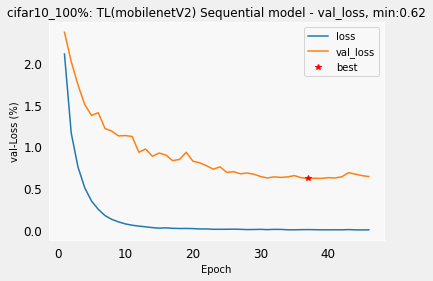

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 loss 시각화.
epochs = range(1, len(history.history['loss']) + 1)

loss_list = history.history['loss'] #[100 * i for i in history.history['loss']]
vloss_list = history.history['val_loss'] #[100 * i for i in history.history['val_loss']]

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],2)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

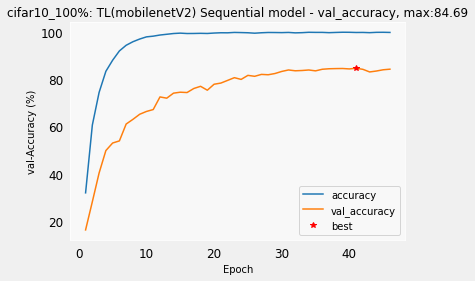

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 accuracy 시각화.
epochs = range(1, len(history.history['accuracy']) + 1)

acc_list = [100 * i for i in history.history['accuracy']]
vacc_list = [100 * i for i in history.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],2)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()

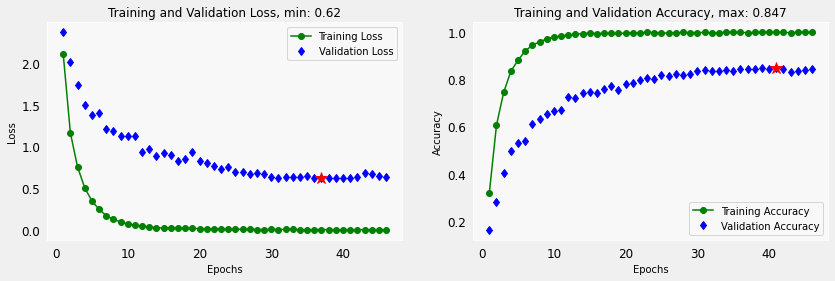

In [ ]:
# More graphs of loss and accuracy
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Unfreeze all layers in base model
tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 143  # 81, 107 for mobilenetV2, 81, 143 for ResNet50

# Freeze all the layers before the `fine_tune_at` layer
for layer in TL_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Compile model
model.compile(optimizer='SGD', 
                loss='categorical_crossentropy',  # categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model1/cifar10pct10_mobileNetV2F_SGD_FT_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [ ]:
INITIAL_EPOCHS = len(loss) #fine tuning 전 단계 - 27
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #

In [ ]:
BATCH_SIZE = 50  # 32, 50, 64, 100
history_fine = model.fit(X_train, y_train, 
                    epochs=TOTAL_EPOCHS, 
                    initial_epoch=INITIAL_EPOCHS,
                    validation_data = (X_test, y_test), 
                    batch_size=BATCH_SIZE,
                    callbacks=[mc_callback,es_callback])

Epoch 47/146
100/100 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9996

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 59s 560ms/step - loss: 0.0041 - accuracy: 0.9996 - val_loss: 0.6399 - val_accuracy: 0.8445
Epoch 48/146
100/100 [==============================] - 55s 550ms/step - loss: 0.0042 - accuracy: 0.9996 - val_loss: 0.6387 - val_accuracy: 0.8455
Epoch 49/146
100/100 [==============================] - 55s 554ms/step - loss: 0.0036 - accuracy: 0.9998 - val_loss: 0.6408 - val_accuracy: 0.8469
Epoch 50/146
100/100 [==============================] - 36s 363ms/step - loss: 0.0034 - accuracy: 0.9998 - val_loss: 0.6444 - val_accuracy: 0.8482
Epoch 51/146
100/100 [==============================] - 55s 552ms/step - loss: 0.0039 - accuracy: 0.9998 - val_loss: 0.6447 - val_accuracy: 0.8487
Epoch 52/146
100/100 [==============================] - 36s 363ms/step - loss: 0.0033 - accuracy: 0.9998 - val_loss: 0.6437 - val_accuracy: 0.8493
Epoch 53/146
100/100 [==============================] - 36s 363ms/step - loss: 0.0033 - accuracy: 0.9998 - val_loss: 0.6436 - val_a

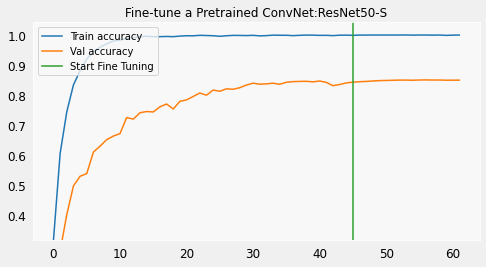

In [ ]:
# Display training curve

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 4))

plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='Val accuracy')
# plt.ylim([0.8, 1])
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(ymin=acc[0]), label='Start Fine Tuning')
plt.title("Fine-tune a Pretrained ConvNet:ResNet50-S")
plt.legend(loc='upper left')

plt.show()

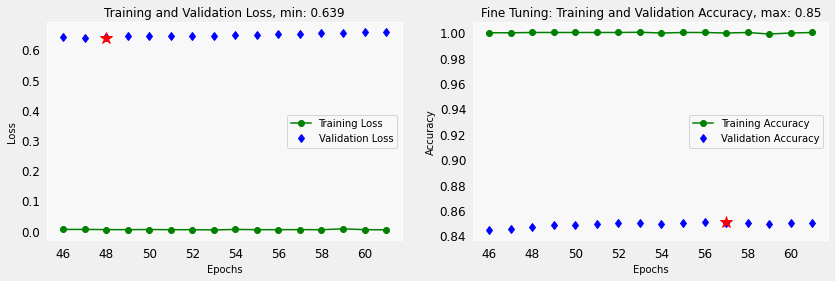

In [ ]:
# More graphs of loss and accuracy in Fine Tuning
history_dict = history_fine.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(INITIAL_EPOCHS, INITIAL_EPOCHS+len(loss))

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(INITIAL_EPOCHS + np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy')#, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(INITIAL_EPOCHS + np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Fine Tuning: Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

###Best Model

> cifar10pct10_mobileNetV2F_SGD_best_weights.041-0.8469.hdf5

> cifar10pct10_mobileNetV2F_SGD_FT_best_weights.057-0.8505.hdf5

In [ ]:
from keras.models import load_model

model_best = load_model('./model1/cifar10pct10_mobileNetV2F_SGD_FT_best_weights.057-0.8505.hdf5')
model_best.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

200/200 [==============================] - 24s 117ms/step - loss: 0.6507 - accuracy: 0.8505


[0.6506709456443787, 0.8504999876022339]

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model_best.predict(X_test)
predictions0 = np.argmax(predictions, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, predictions0)

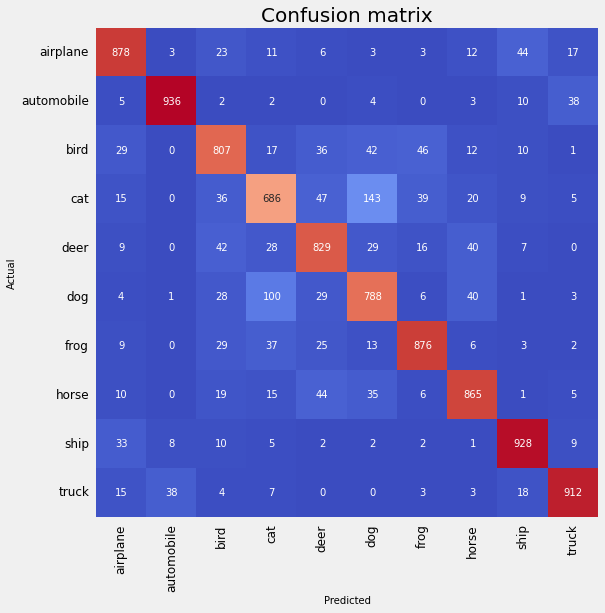

In [ ]:
import seaborn as sns
plt.figure(figsize=(9,9))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()

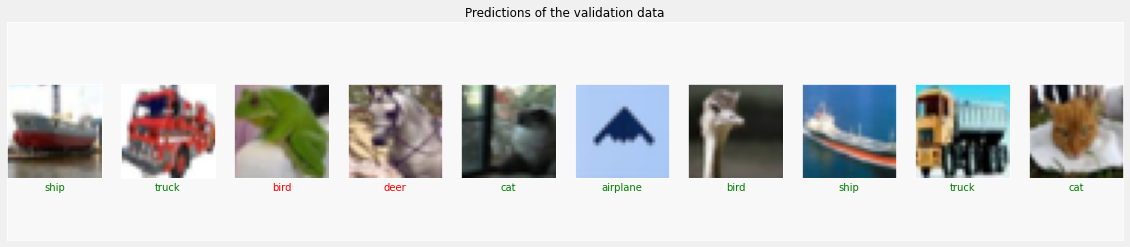

In [ ]:
probabilities = model.predict(X_test, batch_size=BATCH_SIZE)
probabilities = np.argmax(probabilities, axis = 1)

display_images(testX, probabilities, testy, "Predictions of the validation data")